In [34]:
import os
import json
import data_parser
import matplotlib.pyplot as plt
import numpy as np
import CoreLocation
import evaluation
import beaconsHelper
import utils

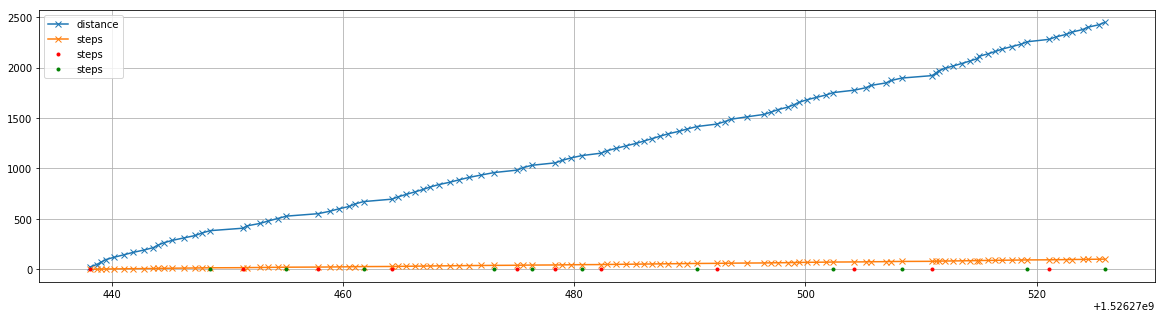

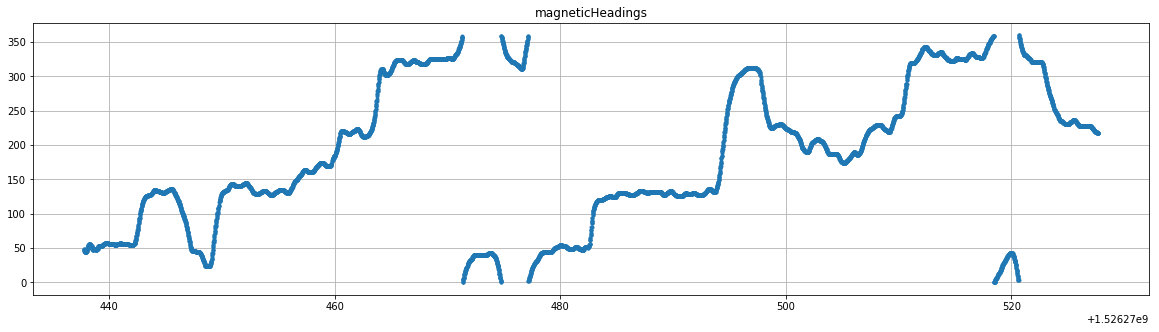

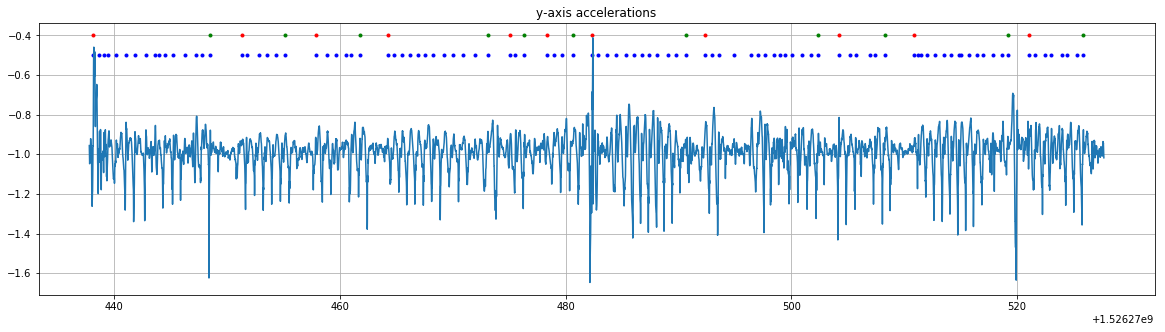

In [2]:
data_label = "cattalyya-13-vertical"
axis = 'y'
# cattalyya-13-stop 1526269978
# cattalyya-13-vertical 1526269430
_, acc_data = data_parser.load_data_all(data_label, start_after_time=1526270430)
    
acc_timestamps = []
magneticHeadings = []
accelerations = []
for entry in acc_data:
    acc_timestamps.append(entry.timestamp)
    magneticHeadings.append(entry.magneticHeading)
    if axis == 'z':
        accelerations.append(entry.zAcceleration)
    elif axis == 'y':
        accelerations.append(entry.yAcceleration)

begin_timestamp = acc_timestamps[0]

ped_timestamps = []
steps = []
distances = []
# for entry in ped_data:
#     ped_timestamps.append(entry.timestamp)
#     steps.append(entry.steps)
#     distances.append(entry.distanceTraveled)
    
step_count, ped_timestamps, steps, distances, walking_timestamps = data_parser.steps_count(acc_data, axis=axis)    

plt.figure(figsize=(20,5))
plt.plot(ped_timestamps, distances, 'x-', label="distance")
plt.plot(ped_timestamps, steps, 'x-', label="steps")
plt.plot([intval[0] for intval in walking_timestamps], [-.4]*len(walking_timestamps), 'r.', label="steps")
plt.plot([intval[1] for intval in walking_timestamps], [-.4]*len(walking_timestamps), 'g.', label="steps")
plt.grid()
plt.legend()
plt.show()

plt.figure(figsize=(20,5))
plt.plot(acc_timestamps, magneticHeadings, '.')
plt.grid()
plt.title("magneticHeadings")
plt.show()

plt.figure(figsize=(20,5))
plt.plot([intval[0] for intval in walking_timestamps], [-.4]*len(walking_timestamps), 'r.', label="steps")
plt.plot([intval[1] for intval in walking_timestamps], [-.4]*len(walking_timestamps), 'g.', label="steps")
plt.plot(ped_timestamps, [-.5]*len(ped_timestamps), 'b.')
plt.plot(acc_timestamps, accelerations, '-')
plt.grid()
plt.title("%s-axis accelerations" % axis)
plt.show()

In [73]:
def high_rssi_beacons(label, threshold):
    best_beacons = []
    data = beaconsHelper.load_rssi_data(label)

    data_by_id = {}
    rssi_data_by_timestamp = beaconsHelper.get_rssi_data_by_timestamp(data, adjust_time=False)

    room = CoreLocation.Room.import_room_data('room_measurement.json', "G5-may13")
    beacon_locations = room.beacons.get_dict_by_label()
    predicted_locations = CoreLocation.Locations()

    for beacon_id in range(1, 10):
        ibeacon = beaconsHelper.get_rssi_data_from_id(beacon_id, rssi_data_by_timestamp)
    #     print ibeacon
        ibeacon = beaconsHelper.get_smooth_rssi_data(ibeacon, 10, option="median")
    #     print "\n\n\n",ibeacon
        data_by_id[beacon_id] = ibeacon
    data_by_timestamp = beaconsHelper.convert_rssi_data_by_id_to_timestamp(data_by_id)
    # data_by_timestamp = beaconsHelper.convert_to_rough_timestamp(data_by_timestamp)

    sorted_time = list(sorted(data_by_timestamp.keys()))
    for timestamp in sorted_time:
        best_beacon = None
        for beacon in data_by_timestamp[timestamp]:
            if beacon.rssi < threshold:
                continue
            if not best_beacon:
                best_beacon = beacon
            if beacon.rssi > best_beacon.rssi:
                best_beacon = beacon
        if best_beacon and best_beacon.id != 9:
#             print best_beacon
            best_beacons.append(best_beacon)
#             loc = beacon_locations[best_beacon.id]

#         if loc is not None:
#             predicted_locations.add_np_point(loc, timestamp)
    return best_beacons

In [74]:
threshold = -60
A = -57
n = 2
best_beacons = high_rssi_beacons(data_label, threshold)

In [75]:
best_beacons

[RSSIData(3)@1526270438.12: rssi=-58.0,
 RSSIData(3)@1526270438.62: rssi=-52.0,
 RSSIData(3)@1526270439.62: rssi=-53.5,
 RSSIData(3)@1526270440.62: rssi=-58.5,
 RSSIData(2)@1526270441.62: rssi=-57.5,
 RSSIData(3)@1526270442.62: rssi=-59.0,
 RSSIData(3)@1526270445.62: rssi=-60.0,
 RSSIData(7)@1526270462.63: rssi=-60.0,
 RSSIData(7)@1526270463.62: rssi=-60.0,
 RSSIData(2)@1526270478.62: rssi=-53.0,
 RSSIData(2)@1526270479.62: rssi=-55.0,
 RSSIData(3)@1526270523.82: rssi=-56.5,
 RSSIData(3)@1526270524.82: rssi=-55.0,
 RSSIData(3)@1526270525.82: rssi=-56.0,
 RSSIData(3)@1526270526.82: rssi=-57.0]

In [76]:
def rescale(beacon_coord, current_coord, distance):
    beacon_coord = np.array(beacon_coord)
    current_coord = np.array(current_coord)
    diff_vector = current_coord - beacon_coord
    new_coord = beacon_coord + diff_vector / np.linalg.norm(diff_vector) * distance
    print "%.2f -> %.2f\t\t %s -> %s" % (np.linalg.norm(diff_vector), distance, current_coord, new_coord)
    return new_coord

In [77]:
room = CoreLocation.Room.import_room_data('room_measurement.json', "G5-may13")
# x, y = room.initial_location.coord
coords = {"no_BLE": room.initial_location.coord, "with_BLE": room.initial_location.coord}
locs = {"no_BLE": CoreLocation.Locations(), "with_BLE": CoreLocation.Locations()}
# begin_heading = acc_data[0].magneticHeading
begin_heading = 50 # depend on the room; have not actually measured
best_beacon_index = 0

for i, entry in enumerate(acc_data[:-1]):
    timestamp = entry.timestamp
    heading = entry.magneticHeading
    relative_heading = heading - begin_heading

    heading_radian = np.deg2rad(relative_heading)
    
    speed = data_parser.speed_at_timestamp(ped_timestamps, distances, walking_timestamps, timestamp)
#     speed = 1
    if speed is None:
        continue
    elapsed_time = acc_data[i + 1].timestamp - timestamp
    distance = speed * elapsed_time
    dx = distance * np.cos(heading_radian)
    dy = distance * np.sin(heading_radian)
    for _label in ["with_BLE", "no_BLE"]:
        x, y = coords[_label]
        x += dx
        y += dy
        coords[_label] = x, y
        
    best_beacon = best_beacons[best_beacon_index]
    if timestamp > best_beacon.timestamp:
        beacon_x, beacon_y = filter(lambda beacon: beacon.label == best_beacon.id, room.beacons.points)[0].coord
        distance = beaconsHelper.rssi_to_distance(best_beacon.rssi, A, n, conversion=39.97)
        print best_beacon.id, 
        x, y = coords["with_BLE"]
        x, y = rescale((beacon_x, beacon_y), (x, y), distance)
        coords["with_BLE"] = x, y
#         x, y = beacon_x, beacon_y
        best_beacon_index += 1
    for _label in ["with_BLE", "no_BLE"]:
        locs[_label].add_np_point(coords[_label], timestamp)

3 41.39 -> 44.85		 [23.42803248 15.0019739 ] -> [20.20296    16.25631627]
3 26.37 -> 22.48		 [41.99720894 17.19079041] -> [44.95354573 14.65005667]
3 42.01 -> 26.71		 [100.59006154  16.60003502] -> [86.53960289 10.55604088]
3 57.21 -> 47.50		 [117.50347886  13.86094681] -> [108.08898461  11.50985447]
2 38.64 -> 42.34		 [137.34782676  14.90173491] -> [133.93660244  16.32754309]
3 99.34 -> 50.32		 [159.15316094  20.73252615] -> [111.21119094  10.50168922]
3 135.98 -> 56.46		 [132.55822709 116.24292062] -> [91.29564187 48.26383985]
7 98.13 -> 56.46		 [ 83.29083716 255.10741784] -> [ 47.91965031 277.14468247]
7 56.46 -> 56.46		 [ 47.91965031 277.14468247] -> [ 47.91965031 277.14468247]
2 70.09 -> 25.22		 [103.22348201  -6.61897911] -> [147.89334136  -2.38160994]
2 11.11 -> 31.75		 [182.99869365  -4.8482765 ] -> [201.56799087 -13.85236149]
3 110.29 -> 37.73		 [  88.62557462 -107.02421164] -> [ 71.10984407 -36.61794699]
3 50.89 -> 31.75		 [ 33.95819718 -42.47029474] -> [ 44.5061885  -26.4949

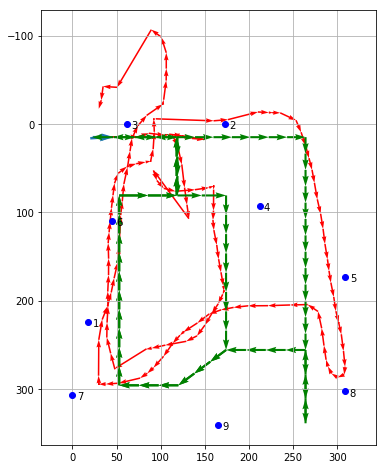

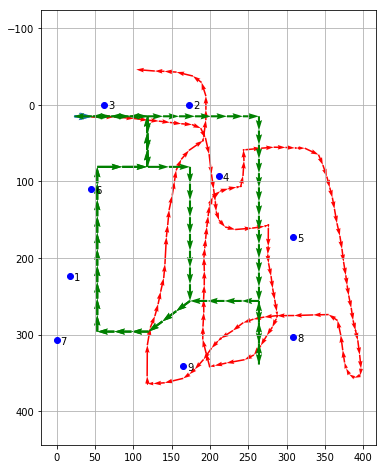

In [78]:
for _label in ["with_BLE", "no_BLE"]:
    room.visualize_with_groundtruth(locs[_label], translate=(0, 0), downsample=50)

# Evaluation

In [79]:
loc_errors_dict = {}
times_dict = {}
for _label in ["with_BLE", "no_BLE"]:
    loc_errors, times = evaluation.evaluate(locs[_label], room.step_landmarks)
    loc_errors_dict[_label] = loc_errors
    times_dict[_label] = times

(20.20296000437488, 16.25631626535811) (23, 15)
(70.6788579733477, 14.319854384161019) (47.0, 15.0)
(100.77204112541529, 12.362104719271978) (71.0, 15.0)
(118.60976753830158, 12.6720439291847) (95.0, 15.0)
(143.55092560262366, 17.10548971511701) (119.0, 15.0)
(116.07276430441239, 16.61770437516384) (119.0, 37.0)
(125.17187138434713, 54.10037549224966) (119.0, 59.0)
(130.1460123279037, 94.03967551781383) (119.0, 81.0)
(91.86448757670506, 53.09211308973311) (146.5, 81.0)
(102.71326411731518, 72.3973243638631) (174.0, 81.0)
(134.29439493973732, 74.94361305387825) (174.0, 102.875)
(159.96313081659923, 70.27170078546209) (174.0, 124.75)
(159.96313081659923, 70.27170078546209) (174.0, 146.625)
(159.96313081659923, 70.27170078546209) (174.0, 168.5)
(159.95066471013877, 84.06726761563165) (174.0, 190.375)
(159.12910741735513, 110.96568271519227) (174.0, 212.25)
(163.68054040666544, 138.41559646978087) (174.0, 234.125)
(168.11505062029357, 167.3759155271389) (174.0, 256.0)
(171.62006526025485, 

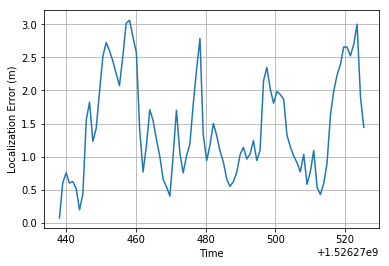

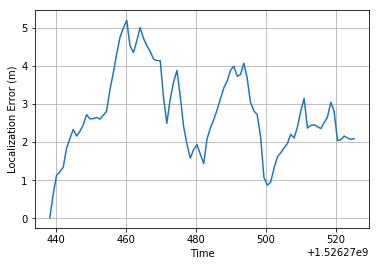

In [80]:
for _label in ["with_BLE", "no_BLE"]:
    loc_errors = np.array(loc_errors_dict[_label])
    loc_errors = utils.in2m(loc_errors)
    plt.plot(times_dict[_label], loc_errors)
    plt.ylabel("Localization Error (m)")
    plt.xlabel("Time")
    plt.grid()
    plt.show()

In [85]:
np.mean(np.array(loc_errors_dict["no_BLE"]))

108.24787341518866

[3.066229491693327, 7.880248517773452, 16.024857800072205, 16.95367228259925, 17.154204394948035, 20.591422577270798, 21.267340008163572, 21.497132156570867, 21.790856139377674, 23.046295537297254, 23.539319298270783, 23.68862412595373, 23.724259792041668, 24.620435606456585, 24.641043705290276, 25.739192572388767, 26.01004051243472, 29.870070698078166, 29.888675519090942, 30.013949614245252, 30.36405812568433, 30.379966873625964, 30.66484052939143, 35.39737657194421, 35.85500757598313, 36.46562871541549, 37.09425390929353, 37.18406125886974, 38.02884137562076, 39.69523289468671, 39.910747428582184, 40.02285992020722, 40.10632342413698, 40.73206599366455, 40.782643021401, 41.182387528833814, 41.45906254811136, 42.71506416893538, 43.07844815454756, 43.11296733169928, 44.933796479802915, 45.235882834447025, 45.926539071007554, 46.11904764199344, 46.92159998259792, 48.54582834740322, 48.9665355183013, 49.47392268956548, 52.15688103396736, 52.1957751824026, 52.571707090928996, 55.629997996

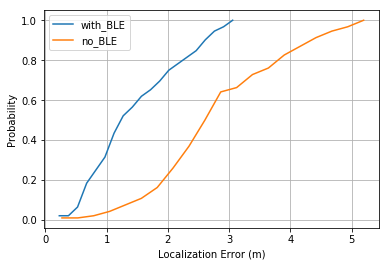

In [82]:
for _label in ["with_BLE", "no_BLE"]:
    loc_errors = loc_errors_dict[_label]
    print sorted(loc_errors)
    loc_errors = utils.in2m(np.array(loc_errors))
    
    counts, bin_edges = np.histogram(loc_errors, bins=20, normed=True)
    cdf = np.cumsum(counts)

    plt.ylabel("Probability")
    plt.xlabel("Localization Error (m)")
    plt.plot(bin_edges[1:], cdf/cdf[-1], label=_label)
    plt.legend()
plt.grid()
plt.show()
